# THE MARCENKO–PASTUR (MP) PDF


Assymptotic distribution of eigenvalues of a specific random matrix. https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution

 The code above shows how well MP pdf explains eigenvalues of random matrix x

In [1]:
400 * 250

100000

In [2]:
12500 / 250

50.0

In [3]:
import matplotlib.pyplot as plt
import numpy as np,pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

C:\Users\r0913246\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N (>1)
    # pts - amount of points
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

In [5]:

def getPCA(matrix):
# Get eVal,eVec from a !!!Hermitian matrix (cov matrix is a hermitian matrix)
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec


def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

In [6]:
15000 / 250

60.0

In [7]:
np.random.seed(32)

N = 1000#1000  # num of vars #N = 250, T = 3000, nFacts = 50 -> Not bad
T = 15000#10000 # num of observations
tmp_nFact = 50
x = np.random.normal(0, 1, size = (T, N))
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.09) #empirical pdf


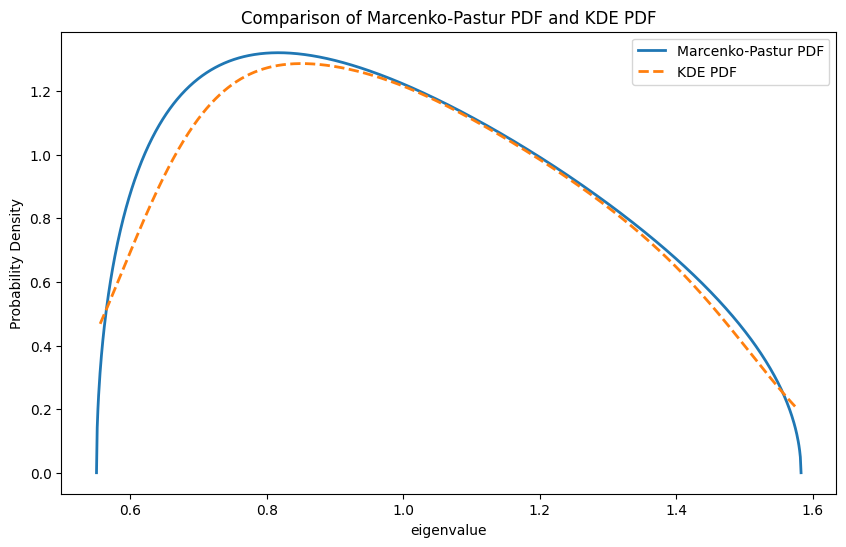

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur PDF', linewidth=2)
plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# MP for not perfectly random function

The code above shows how MP works with not perfectly random function.

_____
Look at RANDOM MATRIX THEORY AND FINANCIAL CORRELATIONS LAURENT LALOUX, PIERRE CIZEAU and MARC POTTERS to understand the approach

In [9]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

In [144]:
import numpy as np

def count_nFactors(T, N, alpha = .999):
    print(f'T={T}, N={N}')
    alpha, nCols, nFact, q = alpha, N, tmp_nFact, T // N
    pdf0 = mpPDF(1., q=q, pts=N)
    cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
    cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
    corr0 = cov2corr(cov)
    eVal01, eVec01 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)
    nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)
    return nFacts0


import numpy as np

def generate_xy_pairs(num_points, x_range=(50, 1500), y_range=(500, 15000)):
    xs = np.linspace(x_range[0], x_range[1], num_points, dtype=int)
    ys = []

    for x in xs:
        # Find a y for this x that is within the y range and ensures y/x is an integer
        possible_ys = [y for y in range(y_range[0], y_range[1]+1) if y % x == 0]
        if not possible_ys:  # If no valid y found within range, skip this x
            continue
        y = np.random.choice(possible_ys)  # Randomly select a valid y
        ys.append(y)

    # Adjusting the lists in case we couldn't find enough valid ys
    xs = xs[:len(ys)]  # Ensure xs and ys are of the same length

    return xs, ys

num_points = 100  # Specify the number of points you want to generate
xs, ys = generate_xy_pairs(num_points)



def get_TNFs(alpha, nPs=100, N_range = (50, 1000), T_range=(500, 15000)):
    Ns, Ts = generate_xy_pairs(nPs, N_range, T_range)
    Fs = [count_nFactors(int(Ts[i]), int(Ns[i]), alpha) for i in range(nPs)]
    
    return np.array(Ts), np.array(Ns), np.array(Fs)

In [151]:
Ts, Ns, Fs = get_TNFs(0.999, 100)

T=2300, N=50
sse:12525.78921157898
sse:12525.78871054742
sse:149.64268995553675
sse:149.64269582908128
found errPDFs0.99999
T=8673, N=59
sse:39786.58596419955
sse:39786.58437273615
sse:186.325483922234
sse:186.3254445386889
sse:159.59935455981494
sse:159.59935297830938
sse:159.5964433097721
sse:159.59644473606497
sse:159.58034912120706
sse:159.58034912125945
sse:159.58034912121028
sse:159.5803491212123
sse:159.58034912120345
sse:159.5803491212411
found errPDFs0.988157252652286
T=3657, N=69
sse:14415.019353374808
sse:14415.018776774054
sse:77.04782777159909
sse:77.04782638665962
sse:76.88164507506409
sse:76.88164646132086
sse:76.40893990561386
sse:76.40893997195181
sse:76.40995872582187
sse:76.40995858911407
sse:76.40860270228958
sse:76.40860270275277
sse:76.40860268639618
sse:76.40860268638949
found errPDFs0.9938985357275907
T=3588, N=78
sse:12525.78921157898
sse:12525.78871054742
sse:91.43869036344682
sse:91.4386858508185
sse:91.58791329935067
sse:91.58790788818607
sse:90.958395782952

sse:8970.461090526225
sse:8970.46068898225
sse:36.91943923333621
sse:36.91942705511566
sse:24.392265473390946
sse:24.392270004810385
sse:21.953382153893052
sse:21.95338298386497
sse:21.9224927538364
sse:21.922492177514908
sse:21.901624985217467
sse:21.90162503043302
sse:21.901486891585566
sse:21.901486893692702
sse:21.90148659360714
sse:21.90148659359862
sse:21.90148659359803
sse:21.901486593597845
found errPDFs0.9753356178856599
T=3765, N=251
sse:3350.7752772087815
sse:3350.7750587475352
sse:7.6934822414854995
sse:7.693481049413619
sse:7.434176170171929
sse:7.4341768481978985
sse:7.344885261928381
sse:7.344885078550447
sse:7.337858813146557
sse:7.337858812717351
sse:7.33785877493246
sse:7.337858774936549
sse:7.337858774931064
sse:7.337858774931063
found errPDFs0.9944611450033379
T=13833, N=261
sse:14415.019353374808
sse:14415.018776774054
sse:121.37877204916657
sse:121.37873840484308
sse:54.6138492380771
sse:54.613857710366176
sse:54.29158587699889
sse:54.2915774975752
sse:52.49669416

sse:15.240388995809264
found errPDFs0.9677019113021111
T=4983, N=453
sse:2108.297222337261
sse:2108.2970709265614
sse:4.7414508261364565
sse:4.741449603741689
sse:4.267773727098666
sse:4.267774870506623
sse:3.2825408438777233
sse:3.282540731190345
sse:3.2783433039002556
sse:3.2783433663122103
sse:3.276447347288691
sse:3.276447347725317
sse:3.276447255307788
sse:3.276447255305672
sse:3.276447255304576
sse:3.276447255304582
found errPDFs0.981051950128146
T=12012, N=462
sse:6765.961915808801
sse:6765.961548332993
sse:43.84115178466571
sse:43.84114024842328
sse:28.15861819476088
sse:28.158626889496368
sse:31.61840339544613
sse:31.61839134250344
sse:16.98186450461512
sse:16.98186512889984
sse:16.94316732844409
sse:16.94316715044208
sse:16.939879183727946
sse:16.93987918761852
sse:16.93987760045693
sse:16.939877600481665
sse:16.939877600405115
sse:16.939877600405083
found errPDFs0.9613781185789101
T=12272, N=472
sse:6773.376998720973
sse:6773.376626781172
sse:45.6327354975433
sse:45.63272359

sse:12.211497004294987
sse:12.211497004254483
sse:12.211497004254422
found errPDFs0.9578337213166623
T=6985, N=635
sse:2088.5760305768695
sse:2088.5758834406074
sse:8.16548445678519
sse:8.16548235025542
sse:6.747590127517814
sse:6.7475921346225975
sse:4.156362104607303
sse:4.1563616388695985
sse:4.086715465458943
sse:4.086715672190772
sse:4.063452955746176
sse:4.063452982215917
sse:4.063097999114626
sse:4.063097997172962
sse:4.063096101513555
sse:4.063096101530315
sse:4.063096101380525
sse:4.063096101380544
found errPDFs0.9688597377841686
T=3864, N=644
sse:854.8424605065442
sse:854.8423960532034
sse:1.9762775076658645
sse:1.9762772506600579
sse:1.927573050811533
sse:1.9275732808539758
sse:1.7820691248172948
sse:1.782069169470219
sse:1.801708024646925
sse:1.8017078639190187
sse:1.7793361250865525
sse:1.7793361300964308
sse:1.7793087618997032
sse:1.7793087609737044
sse:1.7793078144224546
sse:1.7793078144348125
sse:1.7793078142593663
sse:1.779307814259392
found errPDFs0.9798973110229027
T

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:137.04342794416402
sse:137.04341878470825
sse:10.2778571608817
sse:10.277857512229273
found errPDFs0.99999
T=7524, N=836


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:1541.6828014398245
sse:1541.6826910206303
sse:7.493951250090401
sse:7.4939491575099915
sse:5.74961492281194
sse:5.749616554202697
sse:3.444669600909749
sse:3.444669190304878
sse:3.348199245695639
sse:3.3481993688733227
sse:3.338826369345723
sse:3.3388263685397517
sse:3.3388259726038623
sse:3.3388259726109704
sse:3.3388259725765623
sse:3.338825972576568
found errPDFs0.9628941567271369
T=14382, N=846
sse:3852.0190753627944
sse:3852.0188242900535
sse:31.684547198673776
sse:31.684538754289434
sse:19.2006975564587
sse:19.200704284219086
sse:25.56771973607393
sse:25.567708731383366
sse:7.249311919135259
sse:7.249312532374757
sse:7.198689852609697
sse:7.198689579845043
sse:7.186695472841317
sse:7.186695477404582
sse:7.186692083936661
sse:7.186692083969905
sse:7.18669208377345
sse:7.186692083773469
found errPDFs0.9526473484547087
T=10272, N=856
sse:2357.448068161164
sse:2357.447902351218
sse:15.540690505902585
sse:15.540686623151908
sse:11.45694632366834
sse:11.456949491726249
sse:7.588790

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:136.21868914949985
sse:136.21867980489995
sse:9.9001900529217
sse:9.900190398640172
found errPDFs0.99999
T=5250, N=875


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:842.6283033548993
sse:842.6282410221978
sse:2.718615760388842
sse:2.71861511159302
sse:2.41753354826283
sse:2.417534070282005
sse:1.8603864741355323
sse:1.860386512204879
sse:1.8536343215882556
sse:1.853634365188105
sse:1.8440770345131745
sse:1.8440769673311626
sse:1.8419732794881387
sse:1.84197331814942
sse:1.837540564040566
sse:1.8375405641948261
sse:1.8375410653245712
sse:1.8375410647782147
sse:1.8375405205187811
sse:1.8375405205189943
sse:1.837540520518821
sse:1.83754052051882
sse:1.837540520518783
sse:1.837540520518945
sse:1.83754052051879
sse:1.8375405205189863
sse:1.837540520518794
sse:1.8375405205190045
sse:1.8375405205187911
sse:1.8375405205190076
sse:1.8375405205187811
sse:1.8375405205189943
sse:1.837540520518788
sse:1.837540520519
sse:1.8375405205187811
sse:1.8375405205189943
sse:1.837540520518788
sse:1.837540520519
sse:1.8375405205187811
sse:1.8375405205189943
found errPDFs0.9673330543507819
T=14144, N=884
sse:3541.912402673441
sse:3541.9121688999553
sse:28.446166515609

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:130.79629326517778
sse:130.79628456918584
sse:8.8911555087183
sse:8.891155829070124
found errPDFs0.99999
T=11880, N=990


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:2343.2218899175546
sse:2343.221727085231
sse:17.279674323672857
sse:17.279669741546428
sse:11.375480472086405
sse:11.375484409843478
sse:26.491111614008027
sse:26.491103433689517
sse:4.21546800652105
sse:4.215468547943879
sse:4.13219329765405
sse:4.132193103857148
sse:4.120521541180892
sse:4.120521545586957
sse:4.1205154423296335
sse:4.120515442364198
sse:4.120515441971647
sse:4.12051544197163
found errPDFs0.9534094843472858
T=3000, N=1000
sse:301.5943068771796
sse:301.59428242789164
sse:0.7213144686367711
sse:0.7213143988352411
sse:0.7133039449857645
sse:0.7133039874660836
sse:0.7084326367985081
sse:0.7084326398615635
sse:0.7084025597029393
sse:0.7084025601506736
sse:0.7084018898915281
sse:0.7084018898993257
sse:0.7084018896915965
sse:0.7084018896916131
found errPDFs0.9961515277957729


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\1320732973.py:13: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\1320732973.py:28: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100, label='Min num. of obs. times num. able to find all the factors')


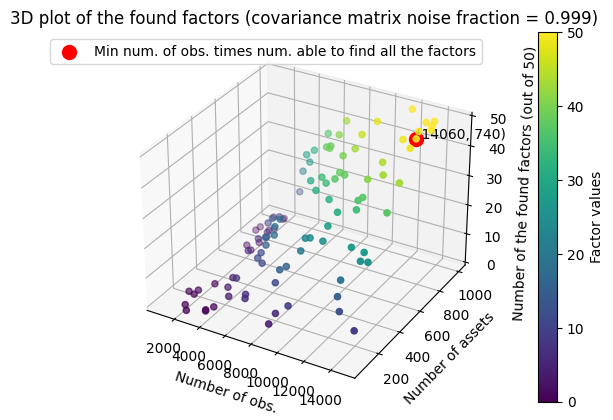

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Ts, Ns, and Fs are numpy arrays and have been correctly computed
Ts_flat = Ts.flatten()
Ns_flat = Ns.flatten()
Fs_flat = Fs.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Fs values
scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')

# Adding a color bar to indicate the scale of Fs values
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('Factor values')

# Filter points where Fs[i] is 50
indices_50 = np.where(Fs_flat == 50)[0]

# If there are any points with Fs[i] == 50
if len(indices_50) > 0:
    # Find the index with the minimum Ts[i] * Ns[i] product among those
    min_product_index = indices_50[np.argmin((Ts_flat[indices_50] * Ns_flat[indices_50]))]

    # Highlight this point in red
    ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100, label='Min num. of obs. times num. able to find all the factors')

    # Annotate the point with its coordinates
    ax.text(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], f"({Ts_flat[min_product_index]}, {Ns_flat[min_product_index]})", color='black')

ax.set_xlabel('Number of obs.')
ax.set_ylabel('Number of assets')
ax.set_zlabel('Number of the found factors (out of 50)')

# Setting the z axis limits as requested
ax.set_zlim(0, 50)
plt.title('3D plot of the found factors (covariance matrix noise fraction = 0.999)')

# Adding a legend
ax.legend()

plt.show()



In [153]:
Ts, Ns, Fs = get_TNFs(0.99, 100)

T=5800, N=50
sse:31405.65357461613
sse:31405.652282157123
sse:3679.7849938878685
sse:3679.785040188079
found errPDFs0.99999
T=4012, N=59
sse:17249.99424456575
sse:17249.99302288081
sse:2118.4810335289126
sse:2118.4810346325457
found errPDFs0.99999
T=11661, N=69
sse:45710.89016242417
sse:45710.888295146586
sse:7402.020283712385
sse:7402.020340988605
found errPDFs0.99999
T=2808, N=78
sse:7194.299114414872
sse:7194.298457732621
sse:944.1941964698715
sse:944.1941840061243
sse:934.587809033179
sse:934.5878172532915
sse:929.9783768661147
sse:929.9783749933061
sse:929.4352444320799
sse:929.4352431720654
sse:929.9015942277036
sse:929.9015974571112
sse:929.2509695888223
sse:929.2509694389264
sse:929.2493310843336
sse:929.2493311356652
sse:929.2491223315876
sse:929.2491223305357
sse:929.2491222426626
sse:929.2491222426561
found errPDFs0.9786461414159275
T=10384, N=88
sse:30794.427688456482
sse:30794.42576316567
sse:5100.053026870659
sse:5100.053097375642
found errPDFs0.99999
T=6014, N=97
sse:141

sse:46.45867233960414
sse:46.45867352716587
sse:42.63443594648193
sse:42.634431507083434
sse:38.864303915422234
sse:38.86430552345683
sse:24.286370777740657
sse:24.286370845560008
sse:25.15830569726446
sse:25.158304713087084
sse:24.280661367890474
sse:24.28066137193995
sse:24.280640118554174
sse:24.280640118666525
sse:24.280640102236962
sse:24.280640102236962
found errPDFs0.7369204377774008
T=13754, N=299
sse:7891.176003710547
sse:7891.175135826692
sse:2602.8796037790826
sse:2602.879610028755
found errPDFs0.99999
T=12978, N=309
sse:6759.0767074347805
sse:6759.075942361027
sse:2327.865063076686
sse:2327.8650610306768
sse:2327.540078555536
sse:2327.540081383577
sse:2325.2029330538808
sse:2325.202938968379
sse:2302.927329424121
sse:2302.9273427272788
sse:2084.1527769508793
sse:2084.152826321584
sse:3782.9494243385525
sse:3782.948891463748
sse:874.0454257815869
sse:874.0455412102192
sse:218.3941084557073
sse:218.3941703451955
sse:179.2216079707202
sse:179.22157776727641
sse:2311.6005078076

sse:177.77275918521852
sse:35.94220522701292
sse:35.9422107820028
sse:18.109531147610642
sse:18.10953157235278
sse:66.4093278926382
sse:66.40931285313448
sse:18.056743029369024
sse:18.05674310804377
sse:18.054901126841532
sse:18.054901125585687
sse:18.05490065857768
sse:18.054900658581282
sse:18.054900658575647
sse:18.05490065857557
found errPDFs0.6869196572685999
T=866, N=433
sse:99.95164890009825
sse:99.95163861075862
sse:18.087527621939017
sse:18.087527128874676
sse:16.895172581900567
sse:16.89517307574937
sse:12.06974237641865
sse:12.06974293373592
sse:81.4040507622636
sse:81.40404216051871
sse:9.040145987036368
sse:9.040146003967601
sse:9.014904543566546
sse:9.014904644559973
sse:9.191919341377666
sse:9.19191910734693
sse:8.9349675946514
sse:8.934967588890487
sse:8.957682245244982
sse:8.957682349075995
sse:8.934902212490378
sse:8.934902211151982
sse:8.934898619270452
sse:8.934898619316243
sse:8.934898615126048
sse:8.934898615125707
found errPDFs0.776394512348345
T=11075, N=443
sse

sse:1786.6737857313954
sse:1786.6735624214225
sse:691.411421817518
sse:691.4114153138428
sse:681.9532031270837
sse:681.9532100557312
sse:626.662633298926
sse:626.6626472431858
sse:69.27442062429557
sse:69.2744448243506
sse:12426337759713.287
sse:12401522313564.012
sse:2596.9647825662323
sse:2596.964496258305
sse:26.0601513174245
sse:26.060157838282073
sse:24.315161736189545
sse:24.3151608516577
sse:89.2470834950012
sse:89.24711074822417
sse:24.287366251031784
sse:24.287366370907527
sse:24.2868380614478
sse:24.28683806266813
sse:24.286838007422126
sse:24.28683800742036
sse:24.28683800742118
sse:24.286838007421206
found errPDFs0.6718816129899781
T=1674, N=558
sse:129.82960003723423
sse:129.8295840963826
sse:41.13237816822566
sse:41.13237722032394
sse:38.331878515730196
sse:38.3318795624676
sse:24.3360557896076
sse:24.336057237623702
sse:354.85920726455834
sse:354.85917011096626
sse:8.660536707485287
sse:8.660537545589431
sse:2371664787910.9136
sse:2366928563854.641
sse:137.7242320809988


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:129.6229608993124
sse:129.62295248475579
sse:19.028881952167136
sse:19.028882230029485
found errPDFs0.99999
T=10472, N=616


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:1631.3810988998232
sse:1631.3808907663542
sse:624.9403868286436
sse:624.9403804455839
sse:614.5962535996854
sse:614.5962611668788
sse:549.7931526674558
sse:549.7931652714266
sse:26.924376263930125
sse:26.924388980492658
sse:11752157853015.814
sse:11728688746833.555
sse:2669.1188624215883
sse:2669.118566380815
sse:18.130276434919047
sse:18.13027464952705
sse:160.21985318186668
sse:160.21988208545898
sse:18.000922306518696
sse:18.000922712569448
sse:17.99373703533647
sse:17.993737039661795
sse:17.99373622484265
sse:17.993736224831366
sse:17.99373622483148
sse:17.99373622483165
found errPDFs0.6744582927948172
T=14375, N=625
sse:2572.5606273088797
sse:2572.560301803748
sse:982.1203427294187
sse:982.1203349111122
sse:971.4905902342092
sse:971.4906004623621
sse:916.4332951087206
sse:916.4333081028992
sse:326.43803705549857
sse:326.43808351153706
sse:159592436.08907485
sse:159591421.60706717
sse:2443.5849931267117
sse:2443.5846805846104
sse:68.9370714813178
sse:68.93710519510637
sse:62.22

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:122.89094405830362
sse:122.8909358797986
sse:18.276142947962704
sse:18.276143172569256
found errPDFs0.99999
T=673, N=673


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:122.90553993897663
sse:122.90553157528636
sse:18.163344446045706
sse:18.16334468430004
found errPDFs0.99999
T=14343, N=683


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:2236.1737602122294
sse:2236.173477631378
sse:836.1604908478607
sse:836.1604834707962
sse:826.748710289041
sse:826.7487180035488
sse:767.0218279458115
sse:767.0218433300062
sse:176.75726213480118
sse:176.75729965088073
sse:14449243947499.324
sse:14420388749611.547
sse:2571.6824512125777
sse:2571.682144630164
sse:38.075063327853115
sse:38.07508483649465
sse:25.905717631950502
sse:25.905704019211328
sse:663.6159926131637
sse:663.616015747391
sse:25.62493812431166
sse:25.62495113242064
sse:20.0569530943922
sse:20.056953013195713
sse:20.056742072604095
sse:20.05674207216849
sse:20.056742066314886
sse:20.056742066314932
found errPDFs0.6738816819650979
T=5536, N=692
sse:512.8117989160265
sse:512.8117339675362
sse:197.75032965427368
sse:197.75032662935752
sse:190.3243847243633
sse:190.32438836392143
sse:148.65441859952986
sse:148.6544242185492
sse:329.60036017530916
sse:329.60031189749384
sse:43.03198504739241
sse:43.031993196890554
sse:8.616714425133582
sse:8.616715423437537
sse:353.68245

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:116.08038091356866
sse:116.08037310468495
sse:17.71216742244293
sse:17.712167589997538
found errPDFs0.99999
T=12750, N=750


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:1568.435131089481
sse:1568.4349281793343
sse:628.5567310638594
sse:628.5567248861053
sse:618.1948963641702
sse:618.1949041064521
sse:559.6423713809556
sse:559.6423835340416
sse:31.538097224976262
sse:31.538114415124653
sse:11752157853169.793
sse:11728688746987.068
sse:2543.5925827477545
sse:2543.592290058561
sse:12.69356651858829
sse:12.693565017917749
sse:138.66226619919863
sse:138.66229436154603
sse:12.613587361648767
sse:12.613587769539159
sse:12.60710096570287
sse:12.607100969467623
sse:12.607100417148853
sse:12.607100417137598
sse:12.607100417138351
sse:12.607100417138287
found errPDFs0.6705626288307565
T=12160, N=760
sse:1437.9278966922477
sse:1437.9277118487032
sse:573.6396520218307
sse:573.6396465700731
sse:564.6574434921604
sse:564.6574506461712
sse:511.2899448101315
sse:511.28995554030445
sse:42.51821705209561
sse:42.518236200902635
sse:11078059049601.193
sse:11055936121422.234
sse:2164.6178820181053
sse:2164.617629182465
sse:11.936549776290788
sse:11.93655102304087
sse:4

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:112.07549426105678
sse:112.0754866549829
sse:17.435058943562925
sse:17.43505909668688
found errPDFs0.99999
T=4962, N=827


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:312.5043433789876
sse:312.50430289415635
sse:128.45536046340163
sse:128.45535809723097
sse:121.23064412056931
sse:121.23064694426031
sse:83.1866620328606
sse:83.18666637424637
sse:812.1549373825759
sse:812.154848643138
sse:23.18210553996775
sse:23.182110379040196
sse:10.374658781990835
sse:10.374654345322195
sse:6.539353979819237
sse:6.539356017106602
sse:4351737227152.426
sse:4343046790524.5854
sse:498.649658989716
sse:498.64959992781
sse:4.885567527017805
sse:4.8855674638731745
sse:128.45536046340163
sse:128.45535809723097
sse:4.887890644930868
sse:4.887890749660492
sse:4.884272217196354
sse:4.884272217198504
sse:4.884272217195884
sse:4.884272217195883
found errPDFs0.6783225685722727
T=13376, N=836
sse:1440.0697984135186
sse:1440.0696119501113
sse:570.337062589373
sse:570.3370552278751
sse:554.9088839470969
sse:554.908892527583
sse:484.29330353777306
sse:484.29331559544653
sse:246.59841340899706
sse:246.5983495687676
sse:407.0247389488476
sse:407.0247581061789
sse:15.698790109959

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:107.95582516988809
sse:107.95581768618862
sse:16.788593531738986
sse:16.78859366012878
found errPDFs0.99999
T=10043, N=913


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:787.7294701994473
sse:787.7293655164353
sse:327.80292652388687
sse:327.8029222540206
sse:318.8153690156879
sse:318.81537400524445
sse:264.1093026267147
sse:264.10931095091047
sse:179.0926941259365
sse:179.09265270882736
sse:211.9781186405836
sse:211.97813004594354
sse:8.0701377028656
sse:8.070142411186668
sse:5.703512948676206
sse:5.703512878378296
sse:6.429925529757417
sse:6.429928265488938
sse:5.70307804329644
sse:5.7030780430705725
sse:5.703078038686581
sse:5.703078038686301
found errPDFs0.6726480313078864
T=14768, N=923
sse:1398.9309984713705
sse:1398.9308152097356
sse:574.289113759293
sse:574.2891078401644
sse:564.7887422830494
sse:564.7887486625136
sse:507.2514287397417
sse:507.2514401328636
sse:8.556833413073099
sse:8.556835687008315
sse:2112.902667143802
sse:2112.90242293236
sse:8.34004001530043
sse:8.340039286080986
sse:8.315468051642018
sse:8.315468055655792
sse:8.315467308341448
sse:8.315467308344928
sse:8.31546730834257
sse:8.315467308342521
sse:8.315467308341468
sse:8.

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:106.32504814358046
sse:106.32504078328614
sse:16.304999441428457
sse:16.304999560972778
found errPDFs0.99999
T=10362, N=942


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:781.4507450689994
sse:781.4506406001044
sse:326.3863230447335
sse:326.3863190254254
sse:318.15412375139454
sse:318.1541286532946
sse:270.3251842461869
sse:270.32519253197523
sse:97.88286140497438
sse:97.88283198429336
sse:207.1431262971555
sse:207.14313744632832
sse:6.803990402253685
sse:6.803994058576364
sse:5.416074326607417
sse:5.416074223177179
sse:7.043641480400141
sse:7.043645416553956
sse:5.415058941820005
sse:5.415058940112573
sse:5.415058663943974
sse:5.415058663942782
sse:5.4150586639432285
sse:5.415058663943231
found errPDFs0.6722981538675933
T=9520, N=952
sse:665.5244457681749
sse:665.5243557493461
sse:286.1743414163702
sse:286.1743377985031
sse:278.50430370844157
sse:278.5043081146299
sse:233.6233322754768
sse:233.623339356913
sse:126.47165629205018
sse:126.47162552101743
sse:185.19717663529758
sse:185.19718624621103
sse:6.499083259169934
sse:6.499086739605321
sse:4.9841685393244015
sse:4.984168435567883
sse:6.736487096847167
sse:6.736490814322148
sse:4.983048833259522

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\1146341135.py:13: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\1146341135.py:28: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100, label='Min num. of obs. times num. able to find all the factors')


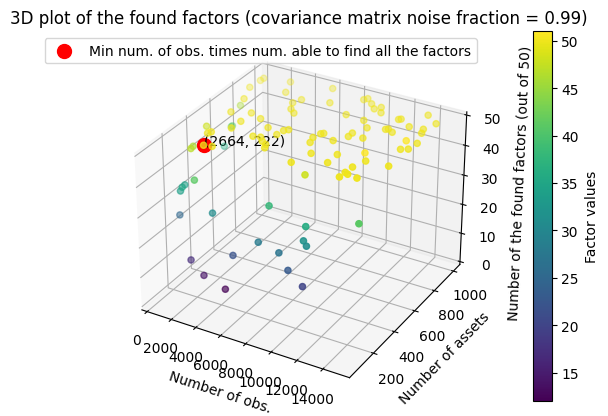

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Ts, Ns, and Fs are numpy arrays and have been correctly computed
Ts_flat = Ts.flatten()
Ns_flat = Ns.flatten()
Fs_flat = Fs.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Fs values
scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')

# Adding a color bar to indicate the scale of Fs values
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('Factor values')

# Filter points where Fs[i] is 50
indices_50 = np.where(Fs_flat == 50)[0]

# If there are any points with Fs[i] == 50
if len(indices_50) > 0:
    # Find the index with the minimum Ts[i] * Ns[i] product among those
    min_product_index = indices_50[np.argmin((Ts_flat[indices_50] * Ns_flat[indices_50]))]

    # Highlight this point in red
    ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100, label='Min num. of obs. times num. able to find all the factors')

    # Annotate the point with its coordinates
    ax.text(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], f"({Ts_flat[min_product_index]}, {Ns_flat[min_product_index]})", color='black')

ax.set_xlabel('Number of obs.')
ax.set_ylabel('Number of assets')
ax.set_zlabel('Number of the found factors (out of 50)')

# Setting the z axis limits as requested
ax.set_zlim(0, 50)
plt.title('3D plot of the found factors (covariance matrix noise fraction = 0.99)')

# Adding a legend
ax.legend()

plt.show()


In [155]:
Ts, Ns, Fs = get_TNFs(0.9, 100)

T=7550, N=50
sse:33274.07985140577
sse:33274.07857604543
sse:8196.836552123797
sse:8196.836719487093
found errPDFs0.99999
T=8791, N=59
sse:33053.651830897594
sse:33053.650600677734
sse:8456.089200634575
sse:8456.089377227489
found errPDFs0.99999
T=4416, N=69
sse:13524.37298935982
sse:13524.372255996837
sse:3572.7686911957685
sse:3572.768755359617
found errPDFs0.99999
T=9828, N=78
sse:30125.606540840025
sse:30125.605450485164
sse:7486.483367715798
sse:7486.483518123712
found errPDFs0.99999
T=1584, N=88
sse:3815.5124796138552
sse:3815.5122921334014
sse:821.7149119277565
sse:821.7149297394418
found errPDFs0.99999
T=8148, N=97
sse:20530.759442990366
sse:20530.7586975333
sse:4851.322471202802
sse:4851.322590540696
found errPDFs0.99999
T=4815, N=107
sse:10999.631415484182
sse:10999.630918327268
sse:2544.295504802294
sse:2544.295558510779
found errPDFs0.99999
T=8775, N=117
sse:19319.059610050506
sse:19319.05877584624
sse:4379.234579148527
sse:4379.2346813354825
found errPDFs0.99999
T=504, N=1

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:236.99562986765693
sse:236.99563107701016
found errPDFs0.99999
T=8805, N=587
sse:4112.578620085503
sse:4112.578469769891
sse:1040.4266508419878
sse:1040.4266716507295
found errPDFs0.99999
T=4768, N=596
sse:2103.9856658180624
sse:2103.985597320742
sse:569.2331071504489
sse:569.2331185352252
found errPDFs0.99999
T=10302, N=606
sse:4679.196518949878
sse:4679.196340597544
sse:1175.2392899852546
sse:1175.2393134902768
found errPDFs0.99999
T=8624, N=616
sse:3843.5428446159503
sse:3843.542706851192
sse:973.037281422008
sse:973.0373008829486
found errPDFs0.99999
T=5000, N=625
sse:2152.034546552096
sse:2152.034474715866
sse:569.2331071504489
sse:569.2331185352252
found errPDFs0.99999
T=2540, N=635
sse:1120.3175733326773
sse:1120.3175479272425
sse:334.76044949704544
sse:334.76045677375356
found errPDFs0.99999
T=1932, N=644
sse:889.0965972117972
sse:889.0965819768737
sse:325.32044744659464
sse:325.3204536615748
found errPDFs0.99999
T=7194, N=654
sse:2974.0871439806697
sse:2974.08704028589
sse

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:380.65467592866685
sse:380.65467145151376
sse:268.7211118692069
sse:268.72111323068174
found errPDFs0.99999
T=4615, N=923


C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: divide by zero encountered in divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\967882101.py:7: RuntimeWarning: invalid value enco

sse:1390.0003354750263
sse:1390.000297541312
sse:371.39793793466487
sse:371.3979459004734
found errPDFs0.99999
T=11184, N=932
sse:3225.2701632697854
sse:3225.2700525640207
sse:838.3075124456345
sse:838.3075292119529
found errPDFs0.99999
T=12246, N=942
sse:3532.9967423011713
sse:3532.996620755419
sse:905.6629024701155
sse:905.6629205835551
found errPDFs0.99999
T=6664, N=952
sse:1887.1226672317302
sse:1887.1226074824783
sse:502.1346309794099
sse:502.1346410220676
found errPDFs0.99999
T=12493, N=961
sse:3552.061132644233
sse:3552.06100767511
sse:905.6629024701155
sse:905.6629205835551
found errPDFs0.99999
T=7768, N=971
sse:2126.6716195646354
sse:2126.671548157972
sse:569.2331071503552
sse:569.2331185351316
found errPDFs0.99999
T=6860, N=980
sse:1881.481114890768
sse:1881.4810543355063
sse:502.1347234800112
sse:502.13473352280477
found errPDFs0.99999
T=7920, N=990
sse:2164.5169979421207
sse:2164.5169254737684
sse:569.2331071504489
sse:569.2331185352252
found errPDFs0.99999
T=2000, N=1000
s

C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\3432531560.py:13: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')
C:\Users\r0913246\AppData\Local\Temp\ipykernel_16696\3432531560.py:28: MatplotlibDeprecationWarning: The clean function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use none, you no longer need to clean a Grouper instead.
  ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100,label='Min num. of obs. times num. able to find all the factors')


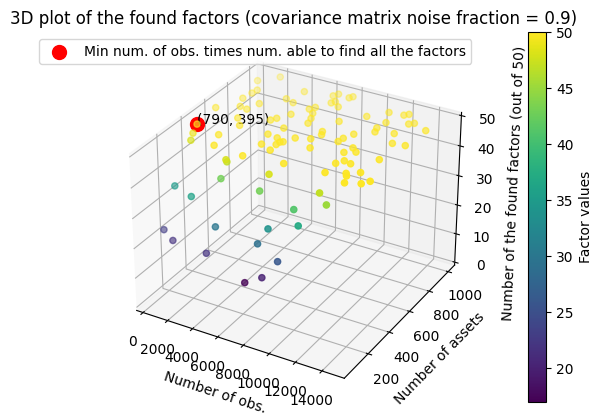

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Ts, Ns, and Fs are numpy arrays and have been correctly computed
Ts_flat = Ts.flatten()
Ns_flat = Ns.flatten()
Fs_flat = Fs.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Fs values
scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')

# Adding a color bar to indicate the scale of Fs values
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('Factor values')

# Filter points where Fs[i] is 50
indices_50 = np.where(Fs_flat == 50)[0]

# If there are any points with Fs[i] == 50
if len(indices_50) > 0:
    # Find the index with the minimum Ts[i] * Ns[i] product among those
    min_product_index = indices_50[np.argmin((Ts_flat[indices_50] * Ns_flat[indices_50]))]

    # Highlight this point in red
    ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100,label='Min num. of obs. times num. able to find all the factors')

    # Annotate the point with its coordinates
    ax.text(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], f"({Ts_flat[min_product_index]}, {Ns_flat[min_product_index]})", color='black')

ax.set_xlabel('Number of obs.')
ax.set_ylabel('Number of assets')
ax.set_zlabel('Number of the found factors (out of 50)')

# Setting the z axis limits as requested
ax.set_zlim(0, 50)
plt.title('3D plot of the found factors (covariance matrix noise fraction = 0.9)')

# Adding a legend
ax.legend()

plt.show()



In [159]:
790 * 395

312050